In [32]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.preprocessing import image 
from sklearn.utils import shuffle

In [2]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [8]:
import cartoon_landmarks as ca

In [33]:
#
name = ['eye_color', 'face_shape']
#data = pd.read_csv('./dataset_AMLS_20-21/celeba/labels.csv',sep='\t',header=0,names = name)
data = pd.read_csv('./dataset_AMLS_20-21/cartoon_set/labels.csv',sep='\t')
Y_A10=data['eye_color']
Y_A11=data['face_shape']

In [48]:
#
#图片读取
train_image = [] 
for i in tqdm(range(data.shape[0])):
    #img = image.load_img('./dataset_AMLS_20-21/celeba/img/'+str(i)+'.jpg', color_mode='rgb', target_size=None, grayscale=False)
    img = image.load_img('./dataset_AMLS_20-21/cartoon_set/img/'+str(i)+'.png', target_size=None, grayscale=False)
    img = image.img_to_array(img)     
    img = img/255     
    train_image.append(img) 


100%|██████████| 10000/10000 [01:34<00:00, 106.05it/s]


MemoryError: Unable to allocate 9.31 GiB for an array with shape (10000, 500, 500, 1) and data type float32

In [54]:
# X = np.array(train_image)
# print(type(X))
print(train_image[250])

[[[255.]
  [255.]
  [255.]
  ...
  [255.]
  [255.]
  [255.]]

 [[255.]
  [255.]
  [255.]
  ...
  [255.]
  [255.]
  [255.]]

 [[255.]
  [255.]
  [255.]
  ...
  [255.]
  [255.]
  [255.]]

 ...

 [[255.]
  [255.]
  [255.]
  ...
  [255.]
  [255.]
  [255.]]

 [[255.]
  [255.]
  [255.]
  ...
  [255.]
  [255.]
  [255.]]

 [[255.]
  [255.]
  [255.]
  ...
  [255.]
  [255.]
  [255.]]]


In [35]:
#
X, Y_A10 = shuffle(X,Y_A10)
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(X, Y_A10,random_state=0)


In [40]:
#
y_train_o = y_train_o.to_numpy()
y_test_o = y_test_o.to_numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [44]:
x_train_o = x_train_o/x_train_o.max()
print(x_train_o.shape,type(y_train_o))

(7500, 500, 500, 1) <class 'numpy.ndarray'>


In [47]:
print(x_train_o[0,0,340,0],type(y_train_o))

1.0 <class 'numpy.ndarray'>


In [55]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn import svm
from sklearn.svm import SVC

In [56]:
import os
import numpy as np
from keras.preprocessing import image
import cv2
import dlib
import pandas as pd
from pathlib import PurePath
#import defusedxml

# PATH TO ALL IMAGES
global basedir, image_paths, target_size
#basedir = './AMLS_assignment20_21-/dataset_AMLS_20-21'
basedir = './dataset_AMLS_20-21'
basedir = os.path.join(basedir,'cartoon_set')
#images_dir = basedir
images_dir = os.path.join(basedir,'img')
labels_filename = 'labels.csv'

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)


def run_dlib_shape(image):
    # in this function we load the image, detect the landmarks of the face, and then return the image and the landmarks
    # load the input image, resize it, and convert it to grayscale
    resized_image = image.astype('uint8')

    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    gray = gray.astype('uint8')

    # detect faces in the grayscale image
    rects = detector(gray, 1)
    num_faces = len(rects)

    if num_faces == 0:
        return None, resized_image

    face_areas = np.zeros((1, num_faces))
    face_shapes = np.zeros((136, num_faces), dtype=np.int64)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        temp_shape = predictor(gray, rect)
        temp_shape = shape_to_np(temp_shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)],
        #   (x, y, w, h) = face_utils.rect_to_bb(rect)
        (x, y, w, h) = rect_to_bb(rect)
        face_shapes[:, i] = np.reshape(temp_shape, [136])
        face_areas[0, i] = w * h
    # find largest face and keep
    dlibout = np.reshape(np.transpose(face_shapes[:, np.argmax(face_areas)]), [68, 2])

    return dlibout, resized_image

# def listToString(s):
#     str1 = " "
#     return (str1.join(s))

def extract_features_labels():
    """
    This funtion extracts the landmarks features for all images in the folder 'dataset/celeba'.
    It also extracts the gender label for each image.
    :return:
        landmark_features:  an array containing 68 landmark points for each image in which a face was detected
        gender_labels:      an array containing the gender label (male=0 and female=1) for each image in
                            which a face was detected
    """
    #print(images_dir)
    image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)]
    target_size = None
    
    # name = ['eye_color', 'face_shape']
    #data = pd.read_csv('./dataset_AMLS_20-21/celeba/labels.csv',sep='\t',header=0,names = name)
    data = pd.read_csv(os.path.join(basedir, labels_filename),sep='\t')
#     Y_A10=data['gender']
#     Y_A11=data['smiling']
#     y_1 = Y_A10
#     y_2 = Y_A11
    eye = data['eye_color']
    faceshape = data['face_shape']
    #print(gender_labels[0:5])

#     labels_file = open(os.path.join(basedir, labels_filename), 'r')
#     lines = labels_file.readlines() 
# # from list get str get array symbols
# for i in range(len(rows)):
#     str0 = listToString(rows[i])
#     y = str0.split('\t')
#     y = np.array(y)
#     Y_A1[i,0] = y[2]
#     Y_A1[i,1] = y[3]
#     #str = str+str0
    #gender_labels = {listToString(line).split('\t')[0] : int(listToString(line).split('\t')[3]) for line in lines[1:]}
    #gender_labels = {listToString(line).split('\t')[3] for line in lines[1:]}

#test    
#     for line in lines[1:10]:
#         #print(line)
#         gender_labels.append(listToString(line).split('\t')[2])
#         a = listToString(line).split('\t')
#         print(np.array(a)[2])
#     #gender_labels = np.array(gender_labels)
                      
    if os.path.isdir(images_dir):
        all_features = []
        all_labels = []
        for img_path in image_paths:
            #print(img_path)
            file_name= PurePath(img_path.split('.')[1]).parts[-1]
            file_name=int(file_name)
            #print(file_name)
            # load image
            img = image.img_to_array(
                image.load_img(img_path,
                               target_size=target_size,
                               interpolation='bicubic'))
            #print(img)
            features, _ = run_dlib_shape(img)
            #print(features)
            if features is not None:
                all_features.append(features)
                #print(gender_labels[file_name])
                all_labels.append(faceshape[file_name])
                #all_labels.append(gender_labels[file_name])
    #print(all_labels)

    landmark_features = np.array(all_features)
#     labels = (np.array(all_labels, dtype=float) + 1)/2 # simply converts the -1 into 0, so male=0 and female=1
    labels = np.array(all_labels)
    return landmark_features, labels

In [57]:
def get_data():

    X, y = extract_features_labels()
    #XX, Y = shuffle(X,y)
#     Y = np.array([y, -(y - 1)]).T
#     tr_X = X[:100]
#     tr_Y = Y[:100]
#     te_X = X[100:]
#     te_Y = Y[100:]
    tr_X, te_X, tr_Y, te_Y = train_test_split(X, y,random_state=0)

    return tr_X, tr_Y, te_X, te_Y

In [59]:
tr_X, tr_Y, te_X, te_Y= get_data()
print(tr_X.shape, te_X.shape)

(6146, 68, 2) (2049, 68, 2)


In [60]:
tr_X = tr_X/tr_X.max()
te_X = te_X/te_X.max()
# print(tr_Y[0:5])
# print(tr_X[0,:,:])

In [76]:
# sklearn functions implementation
def img_SVM(training_images, training_labels, test_images, test_labels):
    classifier = svm.LinearSVC(penalty='l2', multi_class='ovr', random_state=None, max_iter=20000)
#     LinearSVC(penalty='l2', loss='squared_hinge', *, dual=True, tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)
    classifier.fit(training_images, training_labels)
    pred = classifier.predict(test_images)
    print("Accuracy:", accuracy_score(test_labels, pred))

   # print(pred)
    return pred

In [77]:
#faceshape
#max_iter=10000,Accuracy: 0.5485602733040508failed to converge; max_iter=20000,Accuracy: 0.5690580771107857failed to converge;
#max_iter=30000,Accuracy:0.5675939482674476failed to converge;max10000,l2,Accuracy: 0.5285505124450952

#eyecolor
#svm.LinearSVC()：Accuracy: 0.21473889702293802,failed to converge；max_iter=5000:Accuracy: 0.21815519765739386failed converge= =；
#图像归一化后max_iter=5000&10000:Accuracy: 0.3430941922889214 converge;penalty='l1'max_iter=10000:Accuracy: 0.3504148365056125
# pred = img_SVM(x_train.reshape((x_train.shape[0], x_train.shape[1]*x_train.shape[2])), y_train, x_test.reshape((x_test.shape[0], x_test.shape[1]*x_test.shape[2])), y_test)
pred = img_SVM(tr_X.reshape(6146,136), tr_Y, te_X.reshape(2049,136), te_Y)
# pred = img_SVM(x_train_o.reshape(6146,136), y_train_o, x_test_o.reshape(2049,136), y_test_o)

Accuracy: 0.529526598340654


In [61]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras import Model
from tensorflow import keras
import tensorflow as tf

In [62]:
#使输入满足CNN输入格式
tr_X = tr_X.reshape(6146,68,2,1)
te_X = te_X.reshape(2049,68,2,1)

Train on 6146 samples, validate on 2049 samples
Epoch 1/500
6146/6146 [==============================] - 2s 289us/sample - loss: 1.7363 - sparse_categorical_accuracy: 0.2013 - val_loss: 1.6084 - val_sparse_categorical_accuracy: 0.2167
Epoch 2/500
6146/6146 [==============================] - 1s 209us/sample - loss: 1.6507 - sparse_categorical_accuracy: 0.2192 - val_loss: 1.6113 - val_sparse_categorical_accuracy: 0.2143
Epoch 3/500
6146/6146 [==============================] - 1s 208us/sample - loss: 1.6601 - sparse_categorical_accuracy: 0.2105 - val_loss: 1.6096 - val_sparse_categorical_accuracy: 0.1972
Epoch 4/500
6146/6146 [==============================] - 1s 209us/sample - loss: 1.6193 - sparse_categorical_accuracy: 0.2125 - val_loss: 1.6078 - val_sparse_categorical_accuracy: 0.2572
Epoch 5/500
6146/6146 [==============================] - 1s 204us/sample - loss: 1.6152 - sparse_categorical_accuracy: 0.2102 - val_loss: 1.6073 - val_sparse_categorical_accuracy: 0.2147
Epoch 6/500
6146/

6146/6146 [==============================] - 1s 204us/sample - loss: 1.4337 - sparse_categorical_accuracy: 0.4019 - val_loss: 1.4319 - val_sparse_categorical_accuracy: 0.4719
Epoch 45/500
6146/6146 [==============================] - 1s 205us/sample - loss: 1.4192 - sparse_categorical_accuracy: 0.4105 - val_loss: 1.4038 - val_sparse_categorical_accuracy: 0.4690
Epoch 46/500
6146/6146 [==============================] - 1s 205us/sample - loss: 1.4218 - sparse_categorical_accuracy: 0.4047 - val_loss: 1.5008 - val_sparse_categorical_accuracy: 0.3260
Epoch 47/500
6146/6146 [==============================] - 1s 205us/sample - loss: 1.4219 - sparse_categorical_accuracy: 0.3942 - val_loss: 1.4133 - val_sparse_categorical_accuracy: 0.3841
Epoch 48/500
6146/6146 [==============================] - 1s 206us/sample - loss: 1.4040 - sparse_categorical_accuracy: 0.4082 - val_loss: 1.4319 - val_sparse_categorical_accuracy: 0.3514
Epoch 49/500
6146/6146 [==============================] - 1s 205us/sample

Epoch 88/500
6146/6146 [==============================] - 1s 202us/sample - loss: 1.1881 - sparse_categorical_accuracy: 0.5316 - val_loss: 1.6138 - val_sparse_categorical_accuracy: 0.2845
Epoch 89/500
6146/6146 [==============================] - 1s 204us/sample - loss: 1.2470 - sparse_categorical_accuracy: 0.4967 - val_loss: 1.2320 - val_sparse_categorical_accuracy: 0.5105
Epoch 90/500
6146/6146 [==============================] - 1s 204us/sample - loss: 1.1925 - sparse_categorical_accuracy: 0.5371 - val_loss: 1.2735 - val_sparse_categorical_accuracy: 0.4890
Epoch 91/500
6146/6146 [==============================] - 1s 208us/sample - loss: 1.2147 - sparse_categorical_accuracy: 0.5075 - val_loss: 1.3011 - val_sparse_categorical_accuracy: 0.4002
Epoch 92/500
6146/6146 [==============================] - 1s 214us/sample - loss: 1.2044 - sparse_categorical_accuracy: 0.5262 - val_loss: 1.1540 - val_sparse_categorical_accuracy: 0.5637
Epoch 93/500
6146/6146 [==============================] - 1s

6146/6146 [==============================] - 1s 210us/sample - loss: 1.0866 - sparse_categorical_accuracy: 0.5774 - val_loss: 1.1452 - val_sparse_categorical_accuracy: 0.4968
Epoch 132/500
6146/6146 [==============================] - 1s 202us/sample - loss: 1.1366 - sparse_categorical_accuracy: 0.5535 - val_loss: 1.2176 - val_sparse_categorical_accuracy: 0.4368
Epoch 133/500
6146/6146 [==============================] - 1s 202us/sample - loss: 1.0784 - sparse_categorical_accuracy: 0.5833 - val_loss: 1.4605 - val_sparse_categorical_accuracy: 0.3665
Epoch 134/500
6146/6146 [==============================] - 1s 201us/sample - loss: 1.0690 - sparse_categorical_accuracy: 0.5861 - val_loss: 1.0259 - val_sparse_categorical_accuracy: 0.6242
Epoch 135/500
6146/6146 [==============================] - 1s 202us/sample - loss: 1.0762 - sparse_categorical_accuracy: 0.5859 - val_loss: 1.0800 - val_sparse_categorical_accuracy: 0.5915
Epoch 136/500
6146/6146 [==============================] - 1s 201us/s

6146/6146 [==============================] - 1s 221us/sample - loss: 1.0421 - sparse_categorical_accuracy: 0.5955 - val_loss: 1.2155 - val_sparse_categorical_accuracy: 0.4729
Epoch 175/500
6146/6146 [==============================] - 1s 223us/sample - loss: 1.0586 - sparse_categorical_accuracy: 0.5877 - val_loss: 1.0539 - val_sparse_categorical_accuracy: 0.5432
Epoch 176/500
6146/6146 [==============================] - 1s 212us/sample - loss: 1.0259 - sparse_categorical_accuracy: 0.6062 - val_loss: 1.3797 - val_sparse_categorical_accuracy: 0.3607
Epoch 177/500
6146/6146 [==============================] - 1s 214us/sample - loss: 1.0340 - sparse_categorical_accuracy: 0.5911 - val_loss: 1.7055 - val_sparse_categorical_accuracy: 0.2958
Epoch 178/500
6146/6146 [==============================] - 1s 214us/sample - loss: 1.0319 - sparse_categorical_accuracy: 0.6010 - val_loss: 1.7452 - val_sparse_categorical_accuracy: 0.2587
Epoch 179/500
6146/6146 [==============================] - 1s 212us/s

6146/6146 [==============================] - 1s 211us/sample - loss: 0.9873 - sparse_categorical_accuracy: 0.6204 - val_loss: 1.0164 - val_sparse_categorical_accuracy: 0.6193
Epoch 218/500
6146/6146 [==============================] - 1s 212us/sample - loss: 1.0167 - sparse_categorical_accuracy: 0.5991 - val_loss: 1.2581 - val_sparse_categorical_accuracy: 0.4383
Epoch 219/500
6146/6146 [==============================] - 1s 211us/sample - loss: 1.0310 - sparse_categorical_accuracy: 0.6017 - val_loss: 1.3058 - val_sparse_categorical_accuracy: 0.3890
Epoch 220/500
6146/6146 [==============================] - 1s 213us/sample - loss: 1.0419 - sparse_categorical_accuracy: 0.5846 - val_loss: 1.2604 - val_sparse_categorical_accuracy: 0.5237
Epoch 221/500
6146/6146 [==============================] - 1s 212us/sample - loss: 1.0125 - sparse_categorical_accuracy: 0.6142 - val_loss: 1.0798 - val_sparse_categorical_accuracy: 0.5778
Epoch 222/500
6146/6146 [==============================] - 1s 212us/s

6146/6146 [==============================] - 1s 214us/sample - loss: 0.9960 - sparse_categorical_accuracy: 0.6124 - val_loss: 1.5090 - val_sparse_categorical_accuracy: 0.2972
Epoch 261/500
6146/6146 [==============================] - 1s 213us/sample - loss: 1.0036 - sparse_categorical_accuracy: 0.6040 - val_loss: 1.4539 - val_sparse_categorical_accuracy: 0.2992
Epoch 262/500
6146/6146 [==============================] - 1s 214us/sample - loss: 0.9939 - sparse_categorical_accuracy: 0.6162 - val_loss: 1.2653 - val_sparse_categorical_accuracy: 0.4085
Epoch 263/500
6146/6146 [==============================] - 1s 215us/sample - loss: 0.9965 - sparse_categorical_accuracy: 0.6106 - val_loss: 1.1912 - val_sparse_categorical_accuracy: 0.4490
Epoch 264/500
6146/6146 [==============================] - 1s 221us/sample - loss: 0.9872 - sparse_categorical_accuracy: 0.6248 - val_loss: 0.9317 - val_sparse_categorical_accuracy: 0.6545
Epoch 265/500
6146/6146 [==============================] - 1s 214us/s

6146/6146 [==============================] - 1s 213us/sample - loss: 0.9624 - sparse_categorical_accuracy: 0.6295 - val_loss: 1.0696 - val_sparse_categorical_accuracy: 0.5886
Epoch 304/500
6146/6146 [==============================] - 1s 212us/sample - loss: 0.9597 - sparse_categorical_accuracy: 0.6297 - val_loss: 1.4861 - val_sparse_categorical_accuracy: 0.3446
Epoch 305/500
6146/6146 [==============================] - 1s 212us/sample - loss: 0.9957 - sparse_categorical_accuracy: 0.6080 - val_loss: 1.1159 - val_sparse_categorical_accuracy: 0.5442
Epoch 306/500
6146/6146 [==============================] - 1s 213us/sample - loss: 0.9528 - sparse_categorical_accuracy: 0.6354 - val_loss: 1.3132 - val_sparse_categorical_accuracy: 0.4446
Epoch 307/500
6146/6146 [==============================] - 1s 213us/sample - loss: 1.0610 - sparse_categorical_accuracy: 0.5779 - val_loss: 1.3109 - val_sparse_categorical_accuracy: 0.4456
Epoch 308/500
6146/6146 [==============================] - 1s 213us/s

6146/6146 [==============================] - 1s 215us/sample - loss: 1.0169 - sparse_categorical_accuracy: 0.6009 - val_loss: 1.3071 - val_sparse_categorical_accuracy: 0.4773
Epoch 347/500
6146/6146 [==============================] - 1s 214us/sample - loss: 0.9835 - sparse_categorical_accuracy: 0.6180 - val_loss: 1.0822 - val_sparse_categorical_accuracy: 0.5261
Epoch 348/500
6146/6146 [==============================] - 1s 214us/sample - loss: 0.9619 - sparse_categorical_accuracy: 0.6285 - val_loss: 1.3088 - val_sparse_categorical_accuracy: 0.4846
Epoch 349/500
6146/6146 [==============================] - 1s 221us/sample - loss: 1.0127 - sparse_categorical_accuracy: 0.5986 - val_loss: 1.4725 - val_sparse_categorical_accuracy: 0.3382
Epoch 350/500
6146/6146 [==============================] - 1s 214us/sample - loss: 0.9560 - sparse_categorical_accuracy: 0.6276 - val_loss: 1.2324 - val_sparse_categorical_accuracy: 0.4597
Epoch 351/500
6146/6146 [==============================] - 1s 213us/s

6146/6146 [==============================] - 1s 212us/sample - loss: 0.9388 - sparse_categorical_accuracy: 0.6279 - val_loss: 1.3607 - val_sparse_categorical_accuracy: 0.4417
Epoch 390/500
6146/6146 [==============================] - 1s 215us/sample - loss: 0.9296 - sparse_categorical_accuracy: 0.6370 - val_loss: 1.2754 - val_sparse_categorical_accuracy: 0.4895
Epoch 391/500
6146/6146 [==============================] - 1s 213us/sample - loss: 0.9503 - sparse_categorical_accuracy: 0.6269 - val_loss: 1.5561 - val_sparse_categorical_accuracy: 0.2528
Epoch 392/500
6146/6146 [==============================] - 1s 214us/sample - loss: 1.0852 - sparse_categorical_accuracy: 0.5667 - val_loss: 1.4923 - val_sparse_categorical_accuracy: 0.2631
Epoch 393/500
6146/6146 [==============================] - 1s 213us/sample - loss: 0.9728 - sparse_categorical_accuracy: 0.6097 - val_loss: 1.2736 - val_sparse_categorical_accuracy: 0.4832
Epoch 394/500
6146/6146 [==============================] - 1s 216us/s

6146/6146 [==============================] - 1s 215us/sample - loss: 1.0341 - sparse_categorical_accuracy: 0.5869 - val_loss: 1.2240 - val_sparse_categorical_accuracy: 0.4549
Epoch 433/500
6146/6146 [==============================] - 1s 213us/sample - loss: 0.9584 - sparse_categorical_accuracy: 0.6233 - val_loss: 1.0255 - val_sparse_categorical_accuracy: 0.5788
Epoch 434/500
6146/6146 [==============================] - 1s 222us/sample - loss: 0.9591 - sparse_categorical_accuracy: 0.6211 - val_loss: 1.1481 - val_sparse_categorical_accuracy: 0.4568
Epoch 435/500
6146/6146 [==============================] - 1s 214us/sample - loss: 0.9417 - sparse_categorical_accuracy: 0.6372 - val_loss: 1.1247 - val_sparse_categorical_accuracy: 0.4988
Epoch 436/500
6146/6146 [==============================] - 1s 213us/sample - loss: 0.9433 - sparse_categorical_accuracy: 0.6383 - val_loss: 0.9545 - val_sparse_categorical_accuracy: 0.6408
Epoch 437/500
6146/6146 [==============================] - 1s 213us/s

6146/6146 [==============================] - 1s 212us/sample - loss: 0.9013 - sparse_categorical_accuracy: 0.6564 - val_loss: 1.1268 - val_sparse_categorical_accuracy: 0.6052
Epoch 476/500
6146/6146 [==============================] - 1s 214us/sample - loss: 0.9013 - sparse_categorical_accuracy: 0.6541 - val_loss: 1.4225 - val_sparse_categorical_accuracy: 0.3416
Epoch 477/500
6146/6146 [==============================] - 1s 213us/sample - loss: 0.9232 - sparse_categorical_accuracy: 0.6321 - val_loss: 1.1779 - val_sparse_categorical_accuracy: 0.6530
Epoch 478/500
6146/6146 [==============================] - 1s 213us/sample - loss: 0.9397 - sparse_categorical_accuracy: 0.6390 - val_loss: 1.3614 - val_sparse_categorical_accuracy: 0.3651
Epoch 479/500
6146/6146 [==============================] - 1s 213us/sample - loss: 0.8937 - sparse_categorical_accuracy: 0.6570 - val_loss: 1.2257 - val_sparse_categorical_accuracy: 0.4192
Epoch 480/500
6146/6146 [==============================] - 1s 213us/s

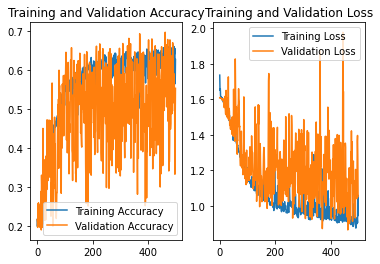

In [65]:
#用landmark提取特征后进行CNN_cartoon
class Baseline(Model):
    def __init__(self):
        super(Baseline, self).__init__()
        self.c1 = Conv2D(filters=16, kernel_size=(3, 3), padding='same')  # 卷积层
        self.b1 = BatchNormalization()  # BN层
        self.a1 = Activation('relu')  # 激活层
        self.p1 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')  # 池化层
        self.d1 = Dropout(0.2)  # dropout层

        self.flatten = Flatten()
        self.f1 = Dense(1024, activation='relu')
        self.d2 = Dropout(0.2)
        self.f2 = Dense(5, activation='softmax')

    def call(self, x):
        x = self.c1(x)
        x = self.b1(x)
        x = self.a1(x)
        x = self.p1(x)
        x = self.d1(x)

        x = self.flatten(x)
        x = self.f1(x)
        x = self.d2(x)
        y = self.f2(x)
        return y


model = Baseline()

opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

# checkpoint_save_path = "./checkpoint/Baseline.ckpt"
# if os.path.exists(checkpoint_save_path + '.index'):
#     print('-------------load the model-----------------')
#     model.load_weights(checkpoint_save_path)

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
#                                                  save_weights_only=True,
#                                                  save_best_only=True)

# #history = model.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test), validation_freq=1,
#                     callbacks=[cp_callback])

# history = model.fit(x_train, y_train, batch_size=128, epochs=5, validation_data=(x_test, y_test), validation_freq=1)
history = model.fit(tr_X, tr_Y, batch_size=128, epochs=500, validation_data=(te_X, te_Y), validation_freq=1)
# history = model.fit(x_train_o, y_train_o, batch_size=128, epochs=10, validation_data=(x_test_o, y_test_o), validation_freq=1)

model.summary()

# print(model.trainable_variables)
file = open('./weights.txt', 'w')
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

###############################################    show   ###############################################

# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

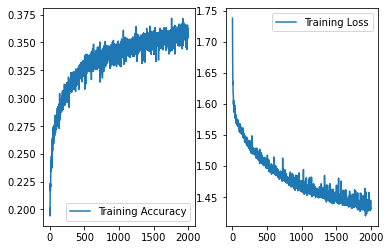

In [30]:
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.title('Training and Validation Loss')
plt.legend()
plt.show()